# Modeling Coronal Loops in 3D with the `sunpy.coordinates` Module

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import astropy.time
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.map import GenericMap
from sunpy.util.metadata import MetaDict
from sunpy.sun import constants as sun_const
from sunpy.coordinates import Helioprojective

%matplotlib inline

The `sunpy.coordinates` module is a useful tool for expressing locations on the Sun in various coordinate systems. While most often used in the context of analyzing and manipulating observational data, we can also use it build three-dimensional models of loops in the corona.

## Getting the Coordinates of a Single Loop

Let's consider a semi-circular loop with both footpoints rooted on the surface of the Sun with a length $L=500$ Mm and centered at a latitude of 0 degrees. We have to do a bit of algebra to find these coordinates, but all we are doing is expressing them in terms of spherical Heliographic Stonyhurst coordinate system.

In [25]:
def semi_circular_loop(length,theta=0*u.deg,n=1000):
    phi = np.linspace(-90,90,n)*u.degree
    r_1 = const.R_sun
    def r_2_func(x):
        return np.arccos(0.5*x/r_1.to(u.cm).value) - np.pi + length.to(u.cm).value/2./x
    r_2 = scipy.optimize.bisect(r_2_func,length.to(u.cm).value/(2*np.pi),
                               length.to(u.cm).value/np.pi) * u.cm
    # Quadratic formula to find r
    a = 1.
    b = -2*r_1.to(u.cm)*np.cos(phi.to(u.radian))
    c = r_1.to(u.cm)**2 - r_2.to(u.cm)**2
    r = (-b + np.sqrt(b**2 - 4*a*c))/2/a 
    # Choose only points above the surface
    i_r = np.where(r>r_1)
    r = r[i_r]
    phi = phi[i_r]
    theta = u.Quantity(r.shape[0]*[theta])
    return SkyCoord(lon=phi,lat=theta,radius=r,frame='heliographic_stonyhurst')

Note that this returns an Astropy `SkyCoord` object. You can read more about these in the Astropy docs [here](http://docs.astropy.org/en/stable/coordinates/index.html). Simply put, a `SkyCoord` object allows us to specify a coordinate-aware set of points in the sky, specifically on the Sun. SunPy provides many of the commonly used solar coordinate systems to be used by `SkyCoord`. You can read more about them [here](http://docs.sunpy.org/en/v0.9.0/code_ref/coordinates.html).

To plot our loop, we need to construct a dummy `sunpy.map.Map` object. This essentially just provides us projected coordinate system so that we can plot our loop in two dimensions.

In [50]:
# Dummy map
data = np.ones((10,10))#*np.nan
time_now = astropy.time.Time.now()
meta = MetaDict({
    'ctype1': 'HPLN-TAN','ctype2': 'HPLT-TAN', 'cunit1': 'arcsec', 'cunit2': 'arcsec',
    'crpix1': (data.shape[0] + 1)/2., 'crpix2': (data.shape[1] + 1)/2.,
    'cdelt1': 1.0, 'cdelt2': 1.0, 'crval1': 0.0, 'crval2': 0.0,
    'hgln_obs': 0.0,
    'hglt_obs': 0.0,
    'dsun_obs': const.au.to(u.m).value,
    'dsun_ref': const.au.to(u.m).value,
    'rsun_ref': const.R_sun.to(u.m).value,
    'rsun_obs': ((const.R_sun / const.au).decompose() * u.radian).to(u.arcsec).value,
    't_obs': time_now.iso,
    'date-obs': time_now.iso,
})
dummy_map = GenericMap(data,meta)

In [27]:
loop = semi_circular_loop(500*u.Mm,n=10000,theta=30*u.deg)

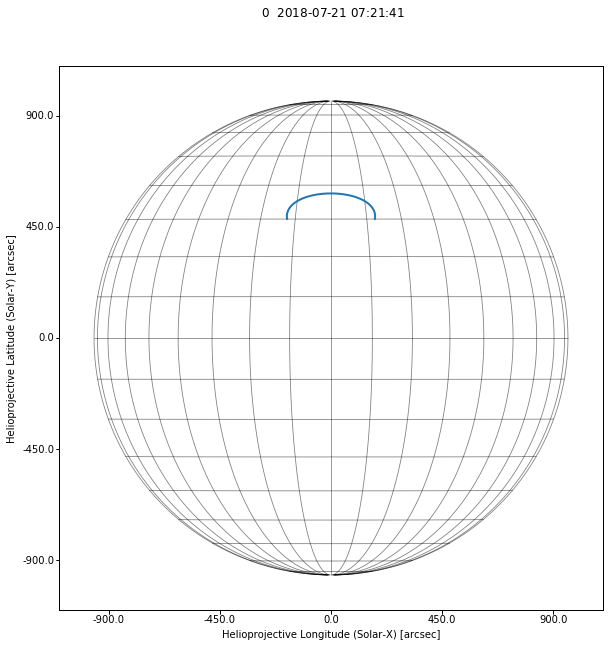

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=dummy_map)
dummy_map.plot(alpha=0)
ax.plot_coord(loop.transform_to(dummy_map.coordinate_frame),color='C0',lw=2)
dummy_map.draw_grid(grid_spacing=10*u.deg,color='k',axes=ax)
ax.plot_coord(SkyCoord(-1000*u.arcsec,-1000*u.arcsec,frame=dummy_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(1000*u.arcsec,1000*u.arcsec,frame=dummy_map.coordinate_frame),color='w',alpha=0)

## Computing the Emission Measure

We want to model the thermodynamics of our loop in three-dimensions as it would be observed on the Sun. For a semi-circular, isothermal loop in static equilibrium, we can estimate the density as a function of $s$ as,

$$
n(s) = n_0\exp\left[\frac{R_{\odot}^2}{\lambda_P}\left(\frac{1}{R_{\odot} + L\sin(\pi s/L)/\pi}
- \frac{1}{R_{\odot}}\right)\right]
$$

where $\lambda_P$ is the pressure scale height. A commonly studied quantity in coronal loop physics is the emission measure distribution. We can then compute the line-of-sight emission measure,

$$
\mathrm{EM} = \int_{LOS}\mathrm{d}h\,n^2
$$

In [51]:
def isothermal_density(loop, length, n0=1e12*u.cm**(-3), T=1*u.MK):
    s = np.linspace(0*length.unit,length,loop.radius.shape[0])
    lambda_p = 2*const.k_B*T/(const.m_p*sun_const.surface_gravity)
    lower_term = const.R_sun + length/np.pi*np.sin((np.pi*s/length).decompose()*u.radian)
    exp_term = (const.R_sun**2)/lambda_p*(1/lower_term - 1/const.R_sun)
    return n0*np.exp(exp_term)

Now, we compute the density as a function of the coordinate $s$ along the loop.

In [109]:
density = isothermal_density(loop,500*u.Mm,T=0.75*u.MK)

## Projecting and Binning 

Now that we have the loop coordinates and the density along the loop, we need to project the loop on the plane of the sky and integrate along the line of sight. First, let's choose an observing location.

In [110]:
observer = SkyCoord(lon=-0*u.deg,lat=0*u.deg,radius=const.au,frame='heliographic_stonyhurst')

Next, we convert the loop to a Helioprojective coordinate system as defined by our observer.

In [111]:
coords = loop.transform_to(Helioprojective(observer=observer))

To perform the projection, we'll use a two-dimensional histogram and bin the $(\theta_x,\theta_y)$ coordinates, using $n^2\Delta z$ as the weights. First, we need to set up the bins for our histogram.

In [112]:
res_x,res_y = 5*u.arcsec/u.pixel,5*u.arcsec/u.pixel
pad_x,pad_y = res_x*5*u.pixel,res_y*5*u.pixel
min_x,max_x,min_y,max_y = coords.Tx.min()-pad_x,coords.Tx.max()+pad_x,coords.Ty.min()-pad_y,coords.Ty.max()+pad_y
min_z,max_z = coords.distance.min(),coords.distance.max()
bins_x = np.ceil((max_x - min_x) / res_x)
bins_y = np.ceil((max_y - min_y) / res_y)
bins_z = max(bins_x, bins_y)

Next, we can compute the weights.

In [113]:
dz = (max_z - min_z).cgs / bins_z * (1. * u.pixel)
em = density**2 * dz.value

We'll exploit our helioprojective coordinate system to figure out what coordinates are blocked by the solar disk and mask those that are.

In [114]:
rsun_obs = ((const.R_sun / (observer.radius - const.R_sun)).decompose()* u.radian).to(u.arcsec)
off_disk = np.sqrt(coords.Tx**2 + coords.Ty**2) > rsun_obs
in_front_of_disk = coords.distance - observer.radius < 0.
visible = np.any(np.stack([off_disk, in_front_of_disk], axis=1), axis=1)

In [115]:
weights = em * visible

In [116]:
hist, _, _ = np.histogram2d(coords.Tx.value, coords.Ty.value,
                            bins=(bins_x.value, bins_y.value),
                            range=((min_x.value,max_x.value), (min_y.value,max_y.value)),
                            weights=weights)

Finally, we'll apply a Gaussian filter to simulate the point spread function of an instrument.

In [117]:
em_hist = gaussian_filter(hist.T, (1.0, 1.0))

In order to make this into a `sunpy.map.Map` object, we also need to construct a header based on the observer location and the field of view of our observed loop.

In [118]:
header = MetaDict({
    'crval1': (min_x + (max_x - min_x)/2).value,
    'crval2': (min_y + (max_y - min_y)/2).value,
    'cunit1': coords.Tx.unit.to_string(),
    'cunit2': coords.Ty.unit.to_string(),
    'hglt_obs': observer.lat.to(u.deg).value,
    'hgln_obs': observer.lon.to(u.deg).value,
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    #'date-obs': time_now.iso,
    'dsun_obs': observer.radius.to(u.m).value,
    'rsun_obs': ((const.R_sun / (observer.radius - const.R_sun))
                 .decompose() * u.radian).to(u.arcsec).value,
    'cdelt1': res_x.value,
    'cdelt2': res_y.value,
    'crpix1': (bins_x.value + 1.0)/2.0,
    'crpix2': (bins_y.value + 1.0)/2.0,
})

In [119]:
em_map = GenericMap(em_hist,header)

Finally, let's plot our loop emission measure!

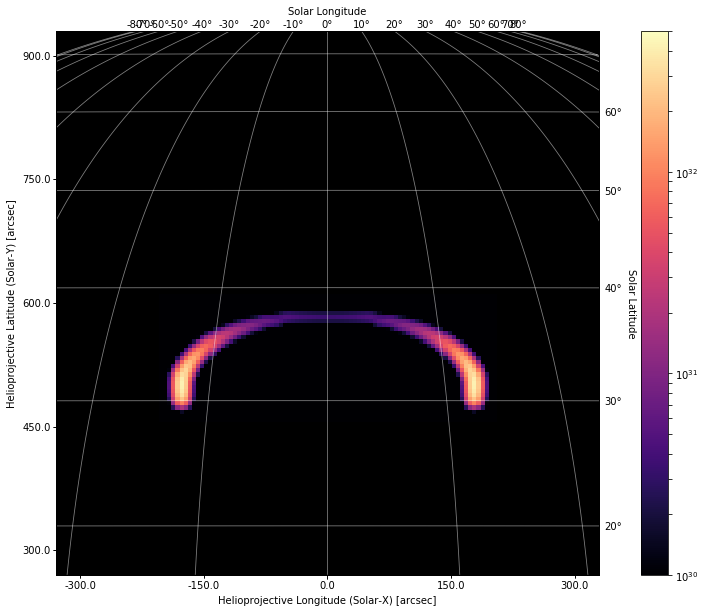

In [120]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection=em_map)
im = em_map.plot(cmap='magma',title=False,
                 norm=matplotlib.colors.SymLogNorm(1,vmin=1e30,vmax=5e32)
                )
em_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(-300*u.arcsec,300*u.arcsec,frame=dummy_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(300*u.arcsec,900*u.arcsec,frame=dummy_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

## Extending to Many Loops
One loop is not all that exciting. Instead, let's model an arcade of loops and choose their lengths from a power-law distribution. We'll write one big function that encapsulates all of the above steps.

In [121]:
def em_arcade(n_loops,observer, length_min=10*u.Mm, length_max=100*u.Mm, theta_min=-10*u.deg,theta_max=10*u.deg):
    # Generate loops
    x = np.random.rand(n_loops)
    alpha = -2.5
    lengths = ((length_max**(alpha + 1.) - length_min**(alpha + 1.))*x + length_min**(alpha + 1.))**(1./(alpha + 1.))
    thetas = np.linspace(theta_min, theta_max, n_loops)
    loops = [semi_circular_loop(l,theta=th,n=2000) for l,th in zip(lengths,thetas)]
    # Stack densities and coordinates and transform
    density = np.hstack([isothermal_density(loop, length, T=0.5*u.MK).value for loop,length in zip(loops,lengths)])
    lon = u.Quantity(np.hstack([l.lon.value for l in loops]),loops[0].lon.unit)
    lat = u.Quantity(np.hstack([l.lat.value for l in loops]),loops[0].lat.unit)
    radius = u.Quantity(np.hstack([l.radius.value for l in loops]),loops[0].radius.unit)
    coords = SkyCoord(lon=lon,lat=lat,radius=radius,frame=loops[0].frame)
    coords = coords.transform_to(Helioprojective(observer=observer))
    # Build histogram
    ## Setup Bins
    res_x,res_y = 5*u.arcsec/u.pixel,5*u.arcsec/u.pixel
    pad_x,pad_y = res_x*5*u.pixel,res_y*5*u.pixel
    min_x,max_x,min_y,max_y = coords.Tx.min()-pad_x,coords.Tx.max()+pad_x,coords.Ty.min()-pad_y,coords.Ty.max()+pad_y
    min_z,max_z = coords.distance.min(),coords.distance.max()
    bins_x = np.ceil((max_x - min_x) / res_x)
    bins_y = np.ceil((max_y - min_y) / res_y)
    bins_z = max(bins_x, bins_y)
    ## Compute Weights
    dz = (max_z - min_z).cgs / bins_z * (1. * u.pixel)
    em = density**2 * dz.value
    rsun_obs = ((const.R_sun / (observer.radius - const.R_sun)).decompose()* u.radian).to(u.arcsec)
    off_disk = np.sqrt(coords.Tx**2 + coords.Ty**2) > rsun_obs
    in_front_of_disk = coords.distance - observer.radius < 0.
    visible = np.any(np.stack([off_disk, in_front_of_disk], axis=1), axis=1)
    weights = em * visible
    # Bin values
    hist, _, _ = np.histogram2d(coords.Tx.value, coords.Ty.value,
                            bins=(bins_x.value, bins_y.value),
                            range=((min_x.value,max_x.value), (min_y.value,max_y.value)),
                            weights=weights)
    em_hist = gaussian_filter(hist.T, (1.0, 1.0))
    # Make header
    header = MetaDict({
        'crval1': (min_x + (max_x - min_x)/2).value,
        'crval2': (min_y + (max_y - min_y)/2).value,
        'cunit1': coords.Tx.unit.to_string(),
        'cunit2': coords.Ty.unit.to_string(),
        'hglt_obs': observer.lat.to(u.deg).value,
        'hgln_obs': observer.lon.to(u.deg).value,
        'ctype1': 'HPLN-TAN',
        'ctype2': 'HPLT-TAN',
        #'date-obs': time_now.iso,
        'dsun_obs': observer.radius.to(u.m).value,
        'rsun_obs': ((const.R_sun / (observer.radius - const.R_sun))
                     .decompose() * u.radian).to(u.arcsec).value,
        'cdelt1': res_x.value,
        'cdelt2': res_y.value,
        'crpix1': (bins_x.value + 1.0)/2.0,
        'crpix2': (bins_y.value + 1.0)/2.0,
    })
    return GenericMap(em_hist,header)

Let's choose a more interesting viewing angle.

In [122]:
observer = SkyCoord(lon=-25*u.deg,lat=-25*u.deg,radius=const.au,frame='heliographic_stonyhurst')
arcade_map = em_arcade(1000,observer,length_min=50*u.Mm,length_max=500*u.Mm,theta_min=-5*u.deg,theta_max=5*u.deg,)

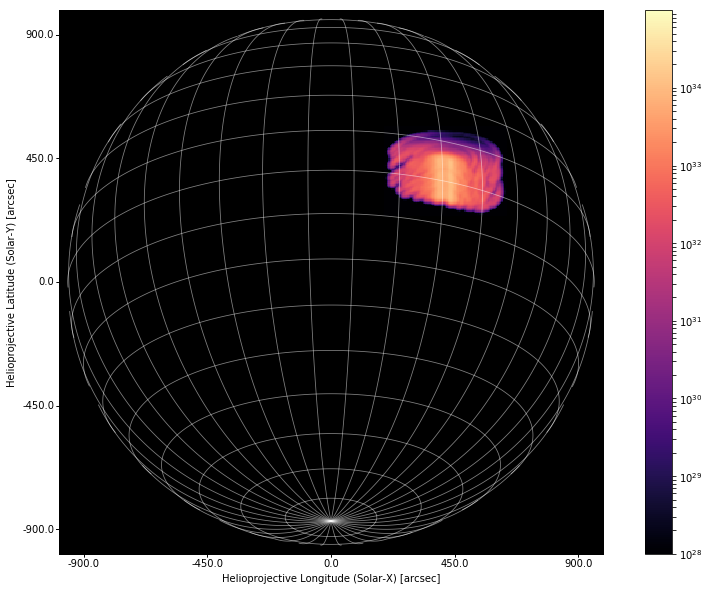

In [123]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection=arcade_map)
im = arcade_map.plot(cmap='magma',title=False,
                     norm=matplotlib.colors.SymLogNorm(1,vmin=1e28,vmax=1e35)
                    )
arcade_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(-900*u.arcsec,-900*u.arcsec,frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(900*u.arcsec,900*u.arcsec,frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

Note that the power of this approach is that we can change the line of sight that our loops are projected along just by adjusting the `SkyCoord` object that represents our observer location. Let's move our observer to the south pole such that we are looking through the arcade of loops.

In [124]:
observer = SkyCoord(lon=0*u.deg,lat=-90*u.deg,radius=const.au,frame='heliographic_stonyhurst')
arcade_map = em_arcade(1000,observer,length_min=50*u.Mm,length_max=500*u.Mm,theta_min=-5*u.deg,theta_max=5*u.deg,)

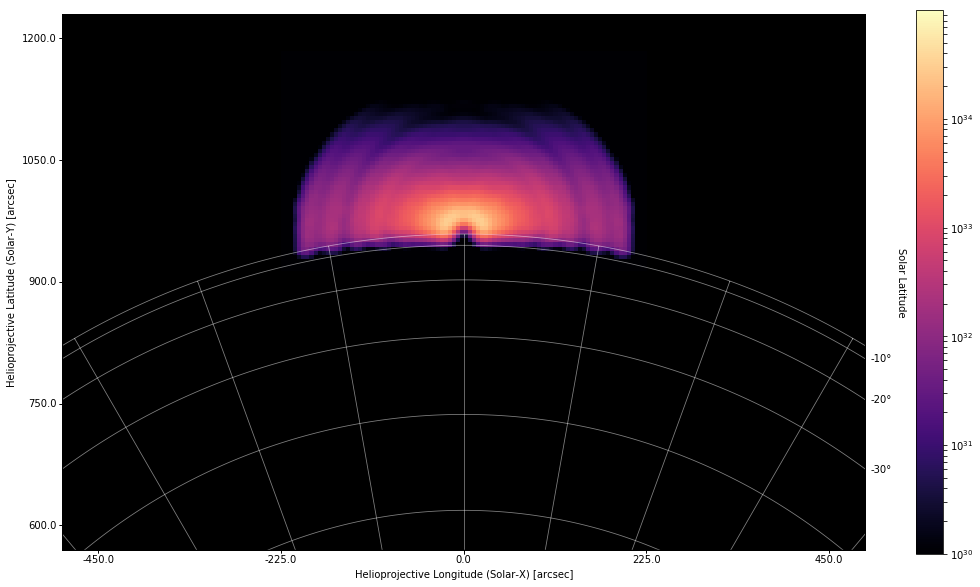

In [125]:
fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection=arcade_map)
im = arcade_map.plot(cmap='magma',title=False,
                     norm=matplotlib.colors.SymLogNorm(1,vmin=1e30,vmax=1e35)
                    )
arcade_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(-450*u.arcsec,600*u.arcsec,frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(450*u.arcsec,1200*u.arcsec,frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

We can even observe the loops off limb. We'll spread them out a bit in $\Theta$ to make them more visible.

In [126]:
observer = SkyCoord(lon=-120*u.deg,lat=0*u.deg,radius=const.au,frame='heliographic_stonyhurst')
arcade_map = em_arcade(1000,observer,length_min=50*u.Mm,length_max=1000*u.Mm,theta_min=-15*u.deg,theta_max=15*u.deg,)

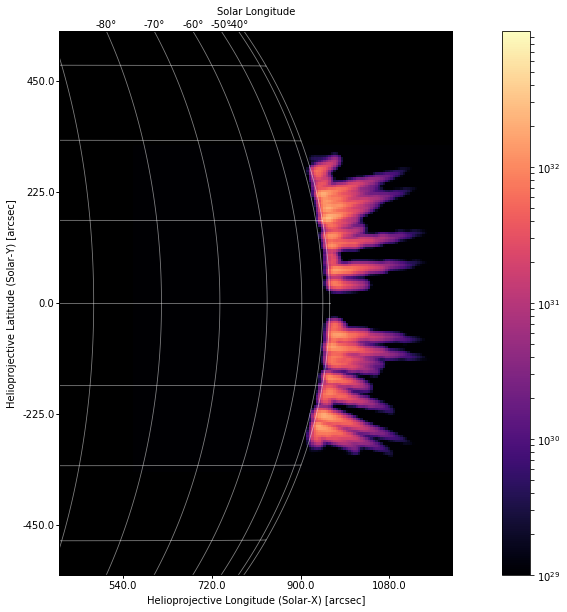

In [127]:
fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection=arcade_map)
im = arcade_map.plot(cmap='magma',title=False,
                     norm=matplotlib.colors.SymLogNorm(1,vmin=1e29,vmax=1e33)
                    )
arcade_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(450*u.arcsec,-500*u.arcsec,frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(1200*u.arcsec,500*u.arcsec,frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

Note that because we've rotated $>90^{\circ}$ around, the far footpoints are masked by the disk.